# HAR (human activity recognition) using DNN/DL on fNIRS data

In [1]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/

P11-4-17-2018/  P13-4-17-2018/  P15-4-18-2018/  P17-4-18-2018/  P19-4-19-2018/
P12-4-17-2018/  P14-4-18-2018/  P16-4-18-2018/  P18-4-19-2018/  P20-4-19-2018/


In [2]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/P12-4-17-2018/

1. Right Hand/  2. Both Hands/  3. Left Hand/  4. Right Leg/  5. Left Leg/


In [3]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/P12-4-17-2018/1.\ Right\ Hand

2018-04-17_006/
fNIR_data.txt
head20180417-145130.txt
NIRS-2018-04-17_006_deoxyhb_T141to2511_C1to20.txt
NIRS-2018-04-17_006_oxyhb_T141to2511_C1to20.txt
Processed/
r_hand20180417-145128.txt
r_lower_arm20180417-145129.txt
r_upper_arm20180417-145129.txt


In [4]:
import numpy as np
import os
import pandas as pd

# % find ../../datasets/fNIRs_data/ | grep fNIR_data # NOT WORKING!!
def find_all(name, path):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    return result

allpaths = find_all(name='fNIR_data.txt', path='/home/arasdar/datasets/fNIRs-data-10subjects/')
allpaths = sorted(allpaths, reverse=False)
# print(allpaths, len(allpaths))
# allpaths, len(allpaths)

In [5]:
# df: data frame object
df = []
for each_idx in range(len(allpaths)):
    file = pd.read_csv(filepath_or_buffer=allpaths[each_idx], names=['time', 'sample', 
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel'],
                         header=None)
    df.append(file)
    
for each in range(len(df)):
#     print(df[each].shape, allpaths[each])
    df[each]=df[each].drop(axis=1, columns=None, index=None, labels=['time', 'sample'])
    df[each] = df[each].dropna()
    df[each]['channel.39'] = df[each]['channel.39'].astype(str).str[1:-1].astype(float)
# print(len(df))

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [6]:
data, labels = [], []
for each in range(0, len(df), 1):
    dfmat = df[each].as_matrix()
    label = allpaths[each][59:60]
#     print(dfmat.dtype, dfmat.shape, label, allpaths[each])
    data.append(dfmat)
    labels.append(label)
len(data), len(labels)

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(48, 48)

In [7]:
# This is very much like a convolution for extracting the windows
# size/width, stride/overlap, padding, dilation, num filters/out channel
def minibatching(X, Y, stride, width):
    Xmb, Ymb = [], []
    print(len(X), len(Y))
    # 1st and 1st
    for eachX in range(len(X)):
        num_mb = ((X[eachX].shape[0]-width)//stride)+1
        for each in range(num_mb):
            # The max is (num_mb-1)*stride+width==X[idx].shape[0]
            # The last each is (num_mb-1)
            # each = ((each-1)*stride)+width
            each *= stride
            Xmb.append(X[eachX][each:each+width])
            # There is only one label for one image signal or signal window or temporal window
            #Ymb.append(Y[eachX][each:each+1])
            Ymb.append(Y[eachX])
    return Xmb, Ymb

In [8]:
# Width is based on the sampling rate which is roughly about 233 points per window
# for 10sec rest and 20 sec activity
width = 250
Xmb, Ymb = minibatching(X=data, Y=labels, stride=1, width=width)
# for eachX, eachY in zip(Xmb, Ymb):
#     print(eachX.shape, eachY)
print(len(Xmb), len(Ymb))
print(Xmb[0].shape, Xmb[0].dtype)
print(Ymb[0])

48 48
69615 69615
(250, 40) float64
1


In [9]:
# Conversion from python list to numpy array
X, Y=np.array(object=Xmb, dtype=float), np.array(object=Ymb, dtype=int)
print(X.shape, X.dtype, Y.shape, Y.dtype)

(69615, 250, 40) float64 (69615,) int64


In [10]:
# Now I should devide the data into train and test
# Train and valid split
from sklearn.model_selection import train_test_split

# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.30)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
print(Xtrain.dtype, Xtest.dtype, Ytrain.dtype, Ytest.dtype)

(48730, 250, 40) (20885, 250, 40) (48730,) (20885,)
float64 float64 int64 int64


In [11]:
# # # standardizing/normalizing the train and test data
# # def standardize(train, test):
# # """ Standardize data """
# # # Standardize train and test
# # X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
# # X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
# # return X_train, X_test

# Xtrain = (Xtrain - Xtrain.mean(axis=0))/ Xtrain.std(axis=0)
# Xtest = (Xtest - Xtest.mean(axis=0))/ Xtest.std(axis=0)
# print(Xtrain.shape, Xtrain.dtype)
# print(Xtest.shape, Xtest.dtype)

In [12]:
print(Xtrain.mean(axis=0), Xtrain.std(axis=0))

[[0.23594646 0.20574769 0.18499014 ... 0.46052898 0.52857991 0.49554941]
 [0.23591926 0.20572009 0.1849515  ... 0.46052541 0.52856091 0.49555147]
 [0.23593237 0.20575106 0.18498347 ... 0.4605055  0.52854632 0.49556102]
 ...
 [0.2358807  0.20630087 0.18540122 ... 0.46148053 0.52974739 0.49816999]
 [0.23588977 0.20630961 0.18546155 ... 0.46148748 0.52976906 0.49815081]
 [0.23585695 0.20628834 0.18545503 ... 0.4614619  0.52977559 0.49814273]] [[0.19309016 0.16596392 0.22235976 ... 0.42521486 0.32923232 0.3948672 ]
 [0.19307609 0.16592236 0.22238214 ... 0.42521889 0.32921259 0.39487239]
 [0.19306619 0.1659696  0.2223575  ... 0.42518518 0.32922182 0.39489675]
 ...
 [0.19375123 0.1661397  0.2229792  ... 0.42468465 0.3309355  0.39807025]
 [0.19375439 0.16615119 0.22302854 ... 0.42472463 0.33090984 0.39801043]
 [0.19375987 0.16614127 0.22304951 ... 0.42467465 0.33090237 0.39800486]]


In [13]:
print(Xtest.mean(axis=0), Xtest.std(axis=0))

[[0.23671737 0.20599588 0.18328772 ... 0.45790687 0.52635682 0.49477223]
 [0.23677955 0.20606606 0.18338711 ... 0.45793073 0.52640483 0.49480061]
 [0.23674619 0.20600102 0.18332116 ... 0.45799424 0.52643625 0.49481557]
 ...
 [0.23670726 0.20650979 0.1839206  ... 0.45877541 0.52765469 0.49794508]
 [0.2366881  0.20649453 0.18378978 ... 0.45876332 0.52762055 0.49799481]
 [0.23677222 0.20655205 0.18381034 ... 0.458833   0.52761424 0.49801809]] [[0.19275917 0.16741378 0.22005106 ... 0.42094319 0.32935872 0.39322057]
 [0.19279758 0.16750025 0.22000945 ... 0.42093943 0.32940743 0.39327233]
 [0.19282259 0.16738574 0.22007569 ... 0.42101616 0.32937906 0.39328182]
 ...
 [0.19345187 0.16746238 0.22088704 ... 0.42043776 0.3307204  0.39709977]
 [0.19344357 0.16744047 0.22076837 ... 0.42034455 0.33081168 0.39725052]
 [0.19343863 0.16747464 0.22072875 ... 0.42046665 0.3308576  0.3972745 ]]


In [14]:
# Now separating train and validation set
# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)
print(Xtrain.shape, Xvalid.shape, Xtest.shape, Xtrain.dtype, Xvalid.dtype, Xtest.dtype)
print(Ytrain.shape, Yvalid.shape, Ytest.shape, Ytrain.dtype, Yvalid.dtype, Ytest.dtype)

(34111, 250, 40) (14619, 250, 40) (20885, 250, 40) float64 float64 float64
(34111,) (14619,) (20885,) int64 int64 int64


In [15]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [16]:
def model_input(input_size, output_size):
    #     N, W, Cin = Xvalid.shape[0], Xvalid.shape[1], Xvalid.shape[2]
    Xinputs = tf.placeholder(dtype=tf.float32, shape=[None, *input_size], name='Xinputs')
    
    #     N, Cout = Yvalid.shape[0], Yvalid.shape[1]
    Yindices = tf.placeholder(dtype=tf.int32, shape=[None], name='Yindices')
    
    # Batchnorm mode: training and inference/testing/validation
    #is_bn_training = tf.placeholder(dtype=tf.bool, shape=[], name='is_bn_training')
    training = tf.placeholder(dtype=tf.bool, shape=[], name='training')

    # returning input data/sequences, output labels/classes
    return Xinputs, Yindices, training

In [17]:
# Discriminator/ classifier/ recognizer
def discriminator(Xinputs, input_size, output_size, hidden_size, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Flatten/Vectorize the input data tensor for FC/fully connected layer/Dense Layer
        Xinputs_vec = tf.reshape(tensor=Xinputs, shape=[-1, input_size[0]*input_size[1]])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=Xinputs_vec, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=output_size)   
        #predictions = tf.nn.softmax(logits)
        
        # return output logits for loss and accuracy
        return logits

In [18]:
# This is the forward propagation of the model to calculate the loss.
def model_loss(Xinputs, Yindices, input_size, output_size, hidden_size, training=True):
    
    # Creating logits and labels
    Ylogits = discriminator(Xinputs=Xinputs, input_size=input_size, output_size=output_size, training=training, 
                            hidden_size=hidden_size)
    Ylabels = tf.one_hot(indices=Yindices, depth=output_size, dtype=Ylogits.dtype)
    
    # Loss using logits and labels
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Ylabels))
    
    # Accuracy using logits and labels
    acc_tensor = tf.equal(x=tf.argmax(axis=1, input=Ylogits), y=tf.argmax(axis=1, input=Ylabels))
    acc = tf.reduce_mean(axis=0, input_tensor=tf.cast(dtype=tf.float32, x=acc_tensor))

    # returning loss and accuracy
    return loss, acc

In [30]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Discriminator/classifier loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    
    # Optimize: Required for BN based on NOTE on TF website for tf.layer.batchnorm
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=t_vars)

    # Returning the optimizer
    return opt

In [31]:
class MLP:
    def __init__(self, input_size, output_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.Xinputs, self.Yindices, self.training = model_input(input_size=input_size, output_size=output_size)

        # Create the Model: calculating the loss and forwad pass
        self.loss, self.acc = model_loss(Xinputs=self.Xinputs, Yindices=self.Yindices, training=self.training,
                                         input_size=input_size, output_size=output_size, hidden_size=hidden_size)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)
        #self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [32]:
def get_batches(X, Y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, Y = X[:n_batches*batch_size], Y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], Y[b:b+batch_size]

In [36]:
# Hidden layer
input_size = [Xvalid.shape[1], Xvalid.shape[2]]
hidden_size = Xvalid.shape[1]* Xvalid.shape[2]
output_size = Yvalid.max()

# learning parameters
batch_size = Xvalid.shape[0]//1 # experience mini-batch size
train_epochs = 10                 # max number of training episodes/epochs
learning_rate = 0.001            # learning rate for training/optimization/adam

In [37]:
print('Yvalid.max(), Yvalid.min():', Yvalid.max(), Yvalid.min())
print('Yvalid.shape:', Yvalid.shape)
print('Xvalid.shape:', Xvalid.shape)

Yvalid.max(), Yvalid.min(): 5 1
Yvalid.shape: (14619,)
Xvalid.shape: (14619, 250, 40)


In [38]:
tf.reset_default_graph()

model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=learning_rate)

In [39]:
# We should save the after training and validation
saver = tf.train.Saver() 

# Loss and accuracy of the model for training and validation
train_loss_mean, valid_loss_mean = [], []
train_acc_mean, valid_acc_mean = [], []

# now that we can calculate loss and optimize, we can start a session for calculating the error.
with tf.Session() as sess:
    
    # Initialize all the model parameters/variables
    sess.run(fetches=tf.global_variables_initializer())
    
    #     # Restoring/loading/uploading the trained and validated model
    #     saver.restore(sess,'checkpoints/mlp-fnirs-har.ckpt')
    
    # for every epoch start feeding the arrays into the tensors in the model
    for epoch in range(train_epochs):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []
        
        # Training
        for Xinputs, Yindices in get_batches(X=Xtrain, Y=Ytrain, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices, model.training: True}
            loss, acc, _ = sess.run(fetches=[model.loss, model.acc, model.opt], feed_dict=feed_dict)
            train_loss.append(loss)
            train_acc.append(acc)
            
        # printing out train and validation loss
        print('epoch:', epoch+1, 'train_loss:', np.mean(train_loss), 'train_acc:', np.mean(train_acc))
        
        # Saving the losses for plotting
        train_loss_mean.append(np.mean(train_loss))
        train_acc_mean.append(np.mean(train_acc))
        
        # Validation: inference mode
        for Xinputs, Yindices in get_batches(X=Xvalid, Y=Yvalid, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices, model.training: False}
            loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
            valid_loss.append(loss)
            valid_acc.append(acc)
        
        # printing out train and validation loss
        print('epoch:', epoch+1, 'valid_loss:', np.mean(valid_loss), 'valid_acc:', np.mean(valid_acc))

        # Saving the losses for plotting
        valid_loss_mean.append(np.mean(valid_loss))
        valid_acc_mean.append(np.mean(valid_acc))        
    
    # Saving the trained and validated model
    saver.save(sess,'checkpoints/mlp-fnirs-har-BN.ckpt')

epoch: 1 train_loss: 8.01772 train_acc: 0.24269786
epoch: 1 valid_loss: 95.1782 valid_acc: 0.10883097
epoch: 2 train_loss: 13.0723505 train_acc: 0.25162458
epoch: 2 valid_loss: 236.17685 valid_acc: 0.10883097
epoch: 3 train_loss: 6.2850943 train_acc: 0.36801422
epoch: 3 valid_loss: 276.10336 valid_acc: 0.10883097
epoch: 4 train_loss: 3.74787 train_acc: 0.39428142
epoch: 4 valid_loss: 283.9643 valid_acc: 0.10883097
epoch: 5 train_loss: 2.8252435 train_acc: 0.4153841
epoch: 5 valid_loss: 281.79367 valid_acc: 0.10883097
epoch: 6 train_loss: 2.2406616 train_acc: 0.39537588
epoch: 6 valid_loss: 263.72586 valid_acc: 0.10883097
epoch: 7 train_loss: 1.6654534 train_acc: 0.44736302
epoch: 7 valid_loss: 227.52979 valid_acc: 0.10883097
epoch: 8 train_loss: 1.2854652 train_acc: 0.45386142
epoch: 8 valid_loss: 202.20016 valid_acc: 0.10883097
epoch: 9 train_loss: 1.3938463 train_acc: 0.3512894
epoch: 9 valid_loss: 183.0421 valid_acc: 0.10883097
epoch: 10 train_loss: 1.1505281 train_acc: 0.440249
epo

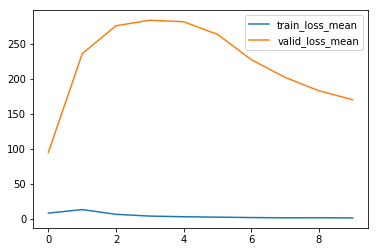

In [40]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss_mean, label='train_loss_mean')
mplot.plot(valid_loss_mean, label='valid_loss_mean')
mplot.legend()

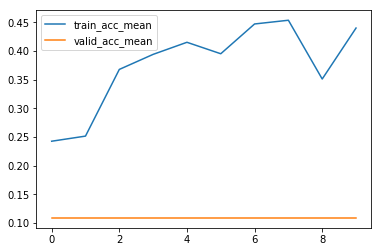

In [41]:
mplot.plot(train_acc_mean, label='train_acc_mean')
mplot.plot(valid_acc_mean, label='valid_acc_mean')
mplot.legend()

In [44]:
with tf.Session() as sess:
    #sess.run(fetches=tf.global_variables_initializer())
    
    # Restoring/loading/uploading the trained and validated model
    saver.restore(sess,'checkpoints/mlp-fnirs-har-BN.ckpt')
    
    # Saving the test loss for every batch/minibtch
    test_loss, test_acc = [], []
    
    # Testing: inference
    for Xinputs, Yindices in get_batches(X=Xtest, Y=Ytest, batch_size=batch_size):
        feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices, model.training: False}
        loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
        test_loss.append(loss)
        test_acc.append(acc)
        
    # Printing the test loss
    print('test_loss:', np.mean(test_loss), 'test acc', np.mean(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/mlp-fnirs-har-BN.ckpt
test_loss: 169.64842 test acc 0.11197756


In [ ]:
INFO:tensorflow:Restoring parameters from checkpoints/mlp-fnirs-har-BN.ckpt
test_loss: 169.64842 test acc 0.11197756